In [67]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
import os
from pathlib import Path

root_dir = Path(os.getcwd()).parent.parent.parent

In [69]:
root_dir


PosixPath('/Users/saral/Documents/cricket/cricket_gardens')

Load the data from the json file

In [70]:
# load data file
data_file = root_dir/"All data/T20_by_countries/Nepal/1415731.json"

# Load JSON
with open(data_file, "r") as f:
    data = json.load(f)

rows = []

# Iterate over innings
for idx, inng in enumerate(data["innings"], start=1):
    team = inng["team"]

    for over_data in inng["overs"]:
        over = over_data["over"]

        for ball_number, delivery in enumerate(over_data["deliveries"], start=1):

            runs = delivery.get("runs", {})
            extras = delivery.get("extras", {})

            # Determine extra type
            if "wides" in extras:
                extra_type = "wide"
            elif "noballs" in extras:
                extra_type = "no_ball"
            elif "legbyes" in extras:
                extra_type = "legbye"
            elif "byes" in extras:
                extra_type = "bye"
            else:
                extra_type = None

            # Wicket details
            wicket_flag = "wickets" in delivery
            if wicket_flag:
                wk = delivery["wickets"][0]
                player_out = wk.get("player_out")
                wicket_kind = wk.get("kind")
                fielders = [f["name"] for f in wk.get("fielders", [])] if "fielders" in wk else []
            else:
                player_out = None
                wicket_kind = None
                fielders = []

            rows.append({
                "innings_number": idx,
                "batting_team": team,
                "over": over,
                "ball_in_over": ball_number,
                "batter": delivery.get("batter"),
                "non_striker": delivery.get("non_striker"),
                "bowler": delivery.get("bowler"),
                "runs_batter": runs.get("batter", 0),
                "runs_extras": runs.get("extras", 0),
                "runs_total": runs.get("total", 0),
                "extra_type": extra_type,
                "is_wicket": wicket_flag,
                "wicket_player_out": player_out,
                "wicket_type": wicket_kind,
                "wicket_fielders": fielders
            })

df = pd.DataFrame(rows)
df.head()


,innings_number,batting_team,over,ball_in_over,batter,non_striker,bowler,runs_batter,runs_extras,runs_total,extra_type,is_wicket,wicket_player_out,wicket_type,wicket_fielders
0,1,South Africa,0,1,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[]
1,1,South Africa,0,2,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[]
2,1,South Africa,0,3,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[]
3,1,South Africa,0,4,RR Hendricks,Q de Kock,Sompal Kami,0,4,4,legbye,False,None,None,[]
4,1,South Africa,0,5,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[]


Create df's for both the innings

In [71]:
# create df where innings_number is 1
df_innings_1 = df[df["innings_number"] == 1]
# create df where innings_number is 2
df_innings_2 = df[df["innings_number"] == 2]

In [72]:
def make_scorecard(df_innings):
    # keep ball_id for batting order
    df = df_innings.reset_index().rename(columns={'index': 'ball_id'})

    # balls faced: exclude wides
    balls_df = df[df['extra_type'] != 'wide'].copy()

    # per-batter aggregation
    scorecard = (
        balls_df.groupby("batter").agg(
            Runs=("runs_batter", "sum"),
            Balls=("runs_batter", "size"),
            Fours=("runs_batter", lambda x: (x == 4).sum()),
            Sixes=("runs_batter", lambda x: (x == 6).sum()),
            Dots=("runs_batter",  lambda x: (x == 0).sum()),
        )
        .reset_index()
        .rename(columns={"batter": "Batsman"})
    )

    # batting order by first appearance
    order = (
        df.groupby("batter")["ball_id"]
        .min()
        .reset_index()
        .rename(columns={"batter": "Batsman", "ball_id": "first_ball"})
    )

    scorecard = (
        scorecard
        .merge(order, on="Batsman", how="left")
        .sort_values("first_ball")
        .drop(columns="first_ball")
    )

    # strike rate & dot percentage per batter
    scorecard["SR"] = (scorecard["Runs"] * 100 / scorecard["Balls"]).round(2)
    scorecard["Dot%"] = (scorecard["Dots"] * 100 / scorecard["Balls"]).round(0)

    # --- totals (batters only) ---
    total_runs_bat = scorecard["Runs"].sum()
    total_balls    = scorecard["Balls"].sum()
    total_fours    = scorecard["Fours"].sum()
    total_sixes    = scorecard["Sixes"].sum()
    total_dots     = scorecard["Dots"].sum()

    extras_total = df_innings["runs_extras"].sum()
    team_total   = total_runs_bat + extras_total

    team_sr   = round(team_total * 100 / total_balls, 2) if total_balls > 0 else 0
    team_dotp = round(total_dots * 100 / total_balls, 0) if total_balls > 0 else 0

    # TOTAL row (batters only)
    total_row = pd.DataFrame([{
        "Batsman": "TOTAL",
        "Runs": total_runs_bat,
        "Balls": total_balls,
        "Fours": total_fours,
        "Sixes": total_sixes,
        "Dots": total_dots,
        "Dot%": team_dotp,
        "SR": ""
    }])

    # EXTRAS row
    extras_row = pd.DataFrame([{
        "Batsman": "EXTRAS",
        "Runs": extras_total,
        "Balls": "",
        "Fours": "",
        "Sixes": "",
        "Dots": "",
        "Dot%": "",
        "SR": "",
    }])

    # GRAND TOTAL row (batters + extras)
    grand_row = pd.DataFrame([{
        "Batsman": "GRAND TOTAL",
        "Runs": team_total,
        "Balls": total_balls,
        "Fours": total_fours,
        "Sixes": total_sixes,
        "Dots": total_dots,
        "Dot%": team_dotp,
        "SR": team_sr,
    }])

    # combine
    scorecard = pd.concat([scorecard, total_row, extras_row, grand_row], ignore_index=True)

    return scorecard


In [73]:
scorecard_1 = make_scorecard(df_innings_1)
scorecard_2 = make_scorecard(df_innings_2)



In [74]:
# South Africa batting scorecard
scorecard_1


,Batsman,Runs,Balls,Fours,Sixes,Dots,SR,Dot%
0,RR Hendricks,43,49,5,1,26,87.76,53.0
1,Q de Kock,10,11,1,0,5,90.91,45.0
2,AK Markram,15,22,2,0,13,68.18,59.0
3,H Klaasen,3,5,0,0,2,60.0,40.0
4,DA Miller,7,10,0,0,4,70.0,40.0
5,T Stubbs,27,18,2,1,5,150.0,28.0
6,M Jansen,1,4,0,0,3,25.0,75.0
7,K Rabada,0,1,0,0,1,0.0,100.0
8,TOTAL,106,120,10,2,59,,49.0
9,EXTRAS,9,,,,,,


In [75]:
# Nepal batting scorecard
scorecard_2

,Batsman,Runs,Balls,Fours,Sixes,Dots,SR,Dot%
0,K Bhurtel,13,21,1,1,16,61.9,76.0
1,Aasif Sheikh,42,49,4,1,25,85.71,51.0
2,RK Paudel,0,2,0,0,2,0.0,100.0
3,AK Sah,27,24,3,1,12,112.5,50.0
4,DS Airee,6,11,0,0,5,54.55,45.0
5,Kushal Malla,1,3,0,0,2,33.33,67.0
6,Sompal Kami,8,4,0,1,2,200.0,50.0
7,Gulsan Jha,6,6,1,0,4,100.0,67.0
8,TOTAL,103,120,9,4,68,,57.0
9,EXTRAS,11,,,,,,


/var/folders/qx/d6vwfn4179979vr76dn4k3440000gn/T/ipykernel_96227/1941507471.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


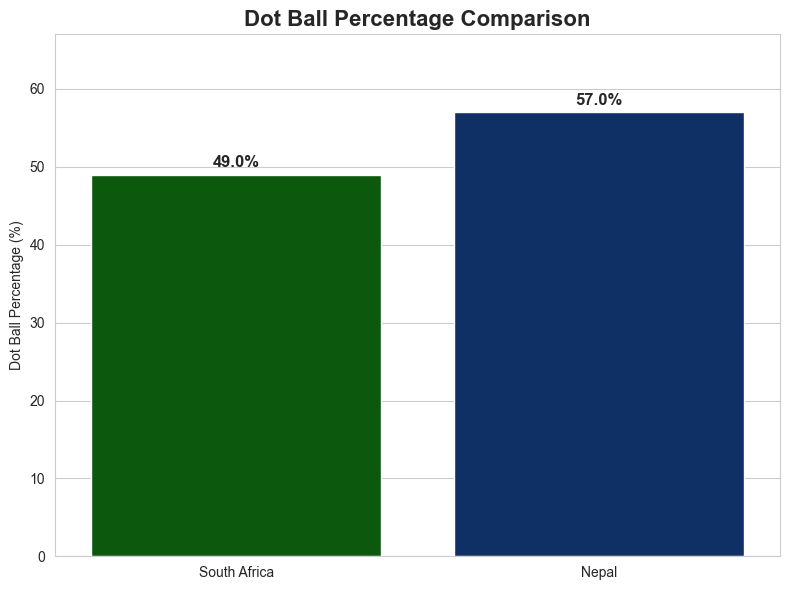

In [76]:
# Just one bar graph
# sa_dots_perc = 49.0
# npl_dots_perc = 57.0
sa_dots_perc = scorecard_1['Dot%'].iloc[-1]
npl_dots_perc = scorecard_2['Dot%'].iloc[-1]

# Data
teams = ['South Africa', 'Nepal']
dot_percentages = [sa_dots_perc, npl_dots_perc]

df = pd.DataFrame({
    'Team': teams,
    'Dot %': dot_percentages
})

# Colors: SA = green/gold gradient, Nepal = dark blue
palette = ['#006400', '#002D72']  # dark green, dark blue

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.barplot(
    data=df,
    x='Team',
    y='Dot %',
    palette=palette
)

# Add annotated percentage labels on each bar
for i, value in enumerate(dot_percentages):
    ax.text(
        i,
        value + 1,
        f"{value:.1f}%",
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

plt.title("Dot Ball Percentage Comparison", fontsize=16, fontweight='bold')
plt.xlabel("")
plt.ylabel("Dot Ball Percentage (%)")
plt.ylim(0, max(dot_percentages) + 10)

plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/dot_ball_percentage_comparison.png", dpi=300,transparent=True)
plt.show()




In [77]:
## innings without wides and no-balls
df_1 = df_innings_1[(df_innings_1['extra_type'] != 'wide') & (df_innings_1['extra_type'] != 'no-ball')].copy()
df_2 = df_innings_2[(df_innings_2['extra_type'] != 'wide') & (df_innings_2['extra_type'] != 'no-ball')].copy()


In [78]:
# runs in the first 6 overs, wickets lost print with /  here wides are important and noballs
print(f"{df_innings_1[df_innings_1.over < 6].runs_total.sum()} / {df_innings_1[(df_innings_1.over < 6) & df_innings_1.is_wicket].shape[0]}")
print(f"{df_innings_2[df_innings_2.over < 6].runs_total.sum()} / {df_innings_2[(df_innings_2.over < 6) & df_innings_2.is_wicket].shape[0]}")


38 / 1
32 / 0


In [79]:
#runs from 7-15 overs and wicket lost in the same 
print(f"{df_innings_1[(df_innings_1.over >= 6) & (df_innings_1.over <=15)]['runs_total'].sum()} / {df_innings_1[(df_innings_1.over >= 6) & (df_innings_1.over <=15) & (df_innings_1.is_wicket) ].shape[0]}")
print(f"{df_innings_2[(df_innings_2.over >= 6) & (df_innings_2.over <=15)]['runs_total'].sum()} / {df_innings_2[(df_innings_2.over >= 6) & (df_innings_2.over <=15) & (df_innings_2.is_wicket) ].shape[0]}")  

47 / 3
63 / 3


In [80]:
# runs in the last 5 overs wickets lost
print(f"{df_innings_1[df_innings_1.over > 15].runs_total.sum()} / {df_innings_1[(df_innings_1.over > 15) & df_innings_1.is_wicket].shape[0]}")
print(f"{df_innings_2[df_innings_2.over > 15].runs_total.sum()} / {df_innings_2[(df_innings_2.over > 15) & df_innings_2.is_wicket].shape[0]}")

30 / 3
19 / 4


In [81]:
# Dot = no run AND not a wide or no-ball
df_innings_1["is_dot"] = (
        ((df_innings_1["runs_batter"] == 0) | 
         (df_innings_1["extra_type"].isin(["bye", "legbye"]))) &
        (~df_innings_1["extra_type"].isin(["wide", "no_ball"]))
    )



In [82]:
df_innings_2["is_dot"] = (
        ((df_innings_2["runs_batter"] == 0) | 
         (df_innings_2["extra_type"].isin(["bye", "legbye"]))) &
        (~df_innings_2["extra_type"].isin(["wide", "no_ball"]))
    )

In [83]:
# Dot balls count for all overs
df_innings_1["is_dot"].sum()


np.int64(59)

In [84]:
# check power play dot balls for innings 1
# print(df_innings_1[df_innings_1.over < 6].is_dot.sum())
pp_dot_ball_sa = df_innings_1[df_innings_1.over < 6].is_dot.sum()
# for middle overs (starting the 7 over to the 15th over)
# print(df_innings_1[(df_innings_1.over >=6) & (df_innings_1.over <=15)].is_dot.sum())
dot_ball_sa_middle = df_innings_1[(df_innings_1.over >=6) & (df_innings_1.over <=15)].is_dot.sum()
# for death overs (Starting from 16th over to the 20th over)
# print(df_innings_1[df_innings_1.over >15].is_dot.sum())
death_over_dot_ball_sa = df_innings_1[df_innings_1.over >15].is_dot.sum()

In [85]:
print(f"pp_dot_ball_sa: {pp_dot_ball_sa}, dot_ball_sa_middle: {dot_ball_sa_middle}, death_over_dot_ball_sa: {death_over_dot_ball_sa}")

pp_dot_ball_sa: 21, dot_ball_sa_middle: 29, death_over_dot_ball_sa: 9


In [86]:
# check power play dot balls for innings 2
# print(df_innings_2[df_innings_2.over < 6].is_dot.sum())
pp_dot_ball_npl = df_innings_2[df_innings_2.over < 6].is_dot.sum()
# for middle overs
# print(df_innings_2[(df_innings_2.over >=6) & (df_innings_2.over <=15)].is_dot.sum())
dot_ball_npl_middle = df_innings_2[(df_innings_2.over >=6) & (df_innings_2.over <=15)].is_dot.sum()
# for death overs
# print(df_innings_2[df_innings_2.over >15].is_dot.sum())
death_over_dot_ball_npl = df_innings_2[df_innings_2.over >15].is_dot.sum()

In [87]:
print(f"pp_dot_ball_npl: {pp_dot_ball_npl}, dot_ball_npl_middle: {dot_ball_npl_middle}, death_over_dot_ball_npl: {death_over_dot_ball_npl}")

pp_dot_ball_npl: 27, dot_ball_npl_middle: 26, death_over_dot_ball_npl: 15


pp_dot_ball_npl: 27, dot_ball_npl_middle: 26, death_over_dot_ball_npl: 15
pp_dot_ball_sa: 21, dot_ball_sa_middle: 29, death_over_dot_ball_sa: 9


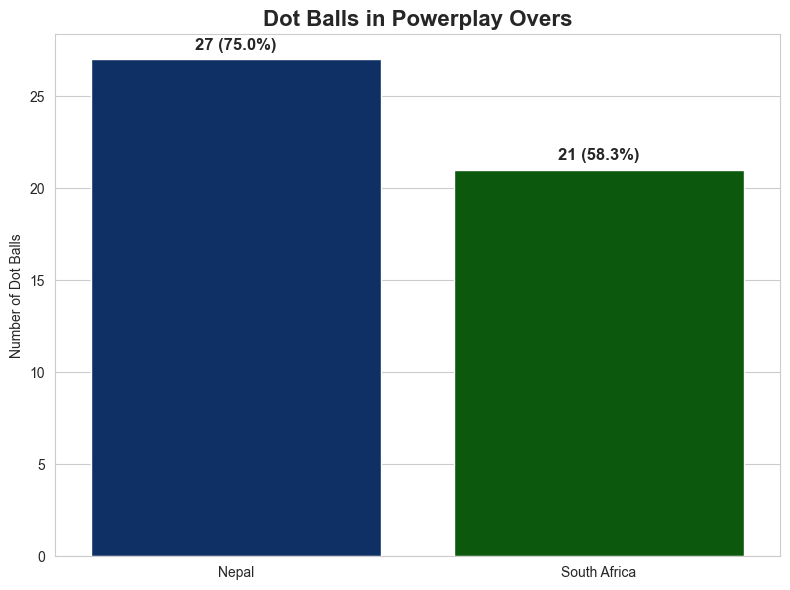

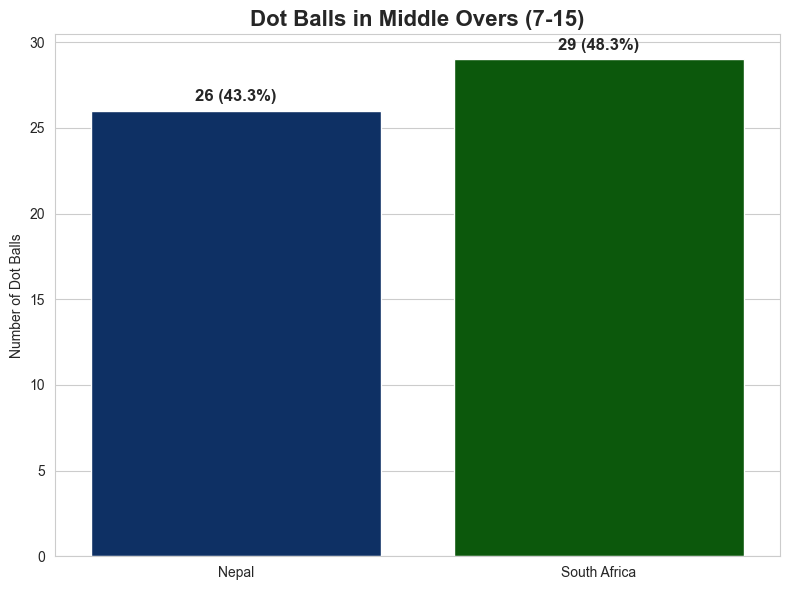

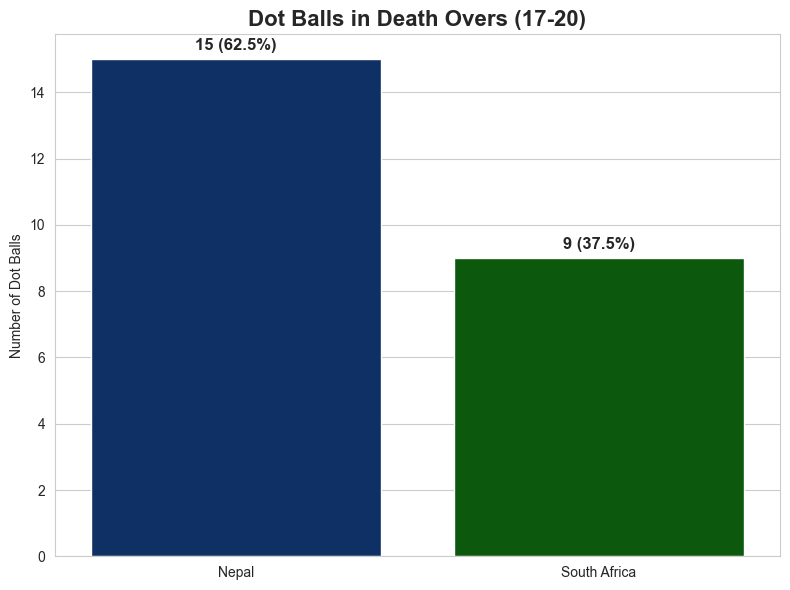

In [93]:
# Seaborn plot Nepal and South Africa dot balls comparison side by side, bar graph
print(f"pp_dot_ball_npl: {pp_dot_ball_npl}, dot_ball_npl_middle: {dot_ball_npl_middle}, death_over_dot_ball_npl: {death_over_dot_ball_npl}")
print(f"pp_dot_ball_sa: {pp_dot_ball_sa}, dot_ball_sa_middle: {dot_ball_sa_middle}, death_over_dot_ball_sa: {death_over_dot_ball_sa}")

# Total balls for each phase
total_pp = 36
total_middle = 60
total_death = 24

# Create three separate plots for each phase

# Powerplay
data_pp = [
    {'Team': 'Nepal', 'Dot Balls': pp_dot_ball_npl},
    {'Team': 'South Africa', 'Dot Balls': pp_dot_ball_sa},
]
df_pp = pd.DataFrame(data_pp)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_pp, x='Team', y='Dot Balls', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = (height / total_pp * 100).round(1)
    ax.annotate(f'{int(height)} ({percentage}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Powerplay Overs', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/dot_balls_powerplay.png", dpi=300, transparent=True)
plt.show()

# Middle Overs
data_md = [
    {'Team': 'Nepal', 'Dot Balls': dot_ball_npl_middle},
    {'Team': 'South Africa', 'Dot Balls': dot_ball_sa_middle},
]
df_md = pd.DataFrame(data_md)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_md, x='Team', y='Dot Balls', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = (height / total_middle * 100).round(1)
    ax.annotate(f'{int(height)} ({percentage}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Middle Overs (7-15)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/dot_balls_middle.png", dpi=300, transparent=True)
plt.show()

# Death Overs
data_dt = [
    {'Team': 'Nepal', 'Dot Balls': death_over_dot_ball_npl},
    {'Team': 'South Africa', 'Dot Balls': death_over_dot_ball_sa},
]
df_dt = pd.DataFrame(data_dt)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_dt, x='Team', y='Dot Balls', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    percentage = (height / total_death * 100).round(1)
    ax.annotate(f'{int(height)} ({percentage}%)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Death Overs (17-20)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/dot_balls_death.png", dpi=300, transparent=True)
plt.show()

In [94]:
# Total balls for each phase
total_pp = 30
total_middle = 66
total_death = 24

weighted_dot_ball_npl = (
    (pp_dot_ball_npl / total_pp) * 0.3 +
    (dot_ball_npl_middle / total_middle) * 0.5 +
    (death_over_dot_ball_npl / total_death) * 0.2
) * 100

print(weighted_dot_ball_npl, npl_dots_perc)

59.1969696969697 57.0


In [95]:
# show total 4 runs runs_batter that were fours in power play overs for innings 2
print(df_innings_2[(df_innings_2.over < 6) ].runs_batter.sum())

# print(df_innings_2[(df_innings_2.over < 6) & (df_innings_2.runs_batter == 4)].runs_batter.sum())
# for middle overs
# print(df_innings_2[(df_innings_2.over >=6) & (df_innings_2.over <=15)].is_dot.sum())
# # for death overs
# print(df_innings_2[df_innings_2.over >15].is_dot.sum())

26


In [96]:
# Nepal Innings 2 powerplay runs_batter value counts
pp_2 = pd.DataFrame(df_2[df_2.over < 6].runs_batter.value_counts())
# South Africa Innings in middle overs
md_2 = pd.DataFrame(df_2[(df_2.over >= 6) & (df_2.over <= 15)].runs_batter.value_counts())
# # South Africa Innings in death overs

dt_2 = pd.DataFrame(df_2[df_2.over > 15].runs_batter.value_counts())

In [97]:
# merge pp_1, md_1, dt_1 dataframes
runs_summary_2 = pp_2.merge(md_2, left_index=True, right_index=True, how='outer', suffixes=('_PP', '_MD'))
runs_summary_2 = runs_summary_2.merge(dt_2, left_index=True, right_index=True, how='outer')
runs_summary_2 = runs_summary_2.rename(columns={0: 'DT'})
runs_summary_2 = runs_summary_2.fillna(0).astype(int)
runs_summary_2

,count_PP,count_MD,count
runs_batter,,,
0,27,26,15
1,4,26,5
2,0,2,2
4,4,4,1
6,1,2,1


In [98]:
# South Africa Innings 2 powerplay runs_batter value counts
pp_1 = pd.DataFrame(df_1[df_1.over < 6].runs_batter.value_counts())
# South Africa Innings in middle overs
md_1 = pd.DataFrame(df_1[(df_1.over >= 6) & (df_1.over <= 15)].runs_batter.value_counts())
# # South Africa Innings in death overs

dt_1 = pd.DataFrame(df_1[df_1.over > 15].runs_batter.value_counts())

In [99]:
# merge pp_1, md_1, dt_1 dataframes
runs_summary = pp_1.merge(md_1, left_index=True, right_index=True, how='outer', suffixes=('_PP', '_MD'))
runs_summary = runs_summary.merge(dt_1, left_index=True, right_index=True, how='outer')
runs_summary = runs_summary.rename(columns={0: 'DT'})
runs_summary = runs_summary.fillna(0).astype(int)
runs_summary

,count_PP,count_MD,count
runs_batter,,,
0,21,29,9
1,9,26,9
2,1,1,3
4,5,3,2
6,0,1,1


In [112]:
df_innings_1

,innings_number,batting_team,over,ball_in_over,batter,non_striker,bowler,runs_batter,runs_extras,runs_total,extra_type,is_wicket,wicket_player_out,wicket_type,wicket_fielders,is_dot
0,1,South Africa,0,1,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[],True
1,1,South Africa,0,2,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[],True
2,1,South Africa,0,3,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[],True
3,1,South Africa,0,4,RR Hendricks,Q de Kock,Sompal Kami,0,4,4,legbye,False,None,None,[],True
4,1,South Africa,0,5,RR Hendricks,Q de Kock,Sompal Kami,0,0,0,None,False,None,None,[],True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1,South Africa,19,2,T Stubbs,M Jansen,K Bhurtel,2,0,2,None,False,None,None,[],False
119,1,South Africa,19,3,T Stubbs,M Jansen,K Bhurtel,0,0,0,None,False,None,None,[],True
120,1,South Africa,19,4,T Stubbs,M Jansen,K Bhurtel,1,0,1,None,False,None,None,[],False
121,1,South Africa,19,5,M Jansen,T Stubbs,K Bhurtel,0,0,0,None,True,M Jansen,caught,[AK Sah],True


In [124]:
# Runs scored in Powerplay, middle overs and death overs for South Africa, 
runs_scored_pp_sa = df_innings_1[df_innings_1.over < 6].runs_batter.sum() + df_innings_1[df_innings_1.over < 6].runs_extras.sum()
runs_scored_md_sa = df_innings_1[(df_innings_1.over >= 6) & (df_innings_1.over <= 15)].runs_batter.sum() + df_innings_1[(df_innings_1.over >= 6) & (df_innings_1.over <= 15)].runs_extras.sum()
runs_scored_dt_sa = df_innings_1[df_innings_1.over > 15].runs_batter.sum() + df_innings_1[df_innings_1.over > 15].runs_extras.sum()
print(f"South Africa - Powerplay: {runs_scored_pp_sa}, Middle Overs: {runs_scored_md_sa}, Death Overs: {runs_scored_dt_sa}")



South Africa - Powerplay: 38, Middle Overs: 47, Death Overs: 30


In [125]:
# Runs scored in Power Play, middle and Death overs by Nepal
runs_scored_pp_npl = df_innings_2[df_innings_2.over < 6].runs_batter.sum() + df_innings_2[df_innings_2.over < 6].runs_extras.sum()
runs_scored_md_npl = df_innings_2[(df_innings_2.over >= 6) & (df_innings_2.over <= 15)].runs_batter.sum() + df_innings_2[(df_innings_2.over >= 6) & (df_innings_2.over <= 15)].runs_extras.sum()
runs_scored_dt_npl = df_innings_2[df_innings_2.over > 15].runs_batter.sum() + df_innings_2[df_innings_2.over > 15].runs_extras.sum()
print(f"Nepal - Powerplay: {runs_scored_pp_npl}, Middle Overs: {runs_scored_md_npl}, Death Overs: {runs_scored_dt_npl}")

Nepal - Powerplay: 32, Middle Overs: 63, Death Overs: 19


South Africa - Powerplay: 38, Middle Overs: 47, Death Overs: 30
Nepal - Powerplay: 32, Middle Overs: 63, Death Overs: 19


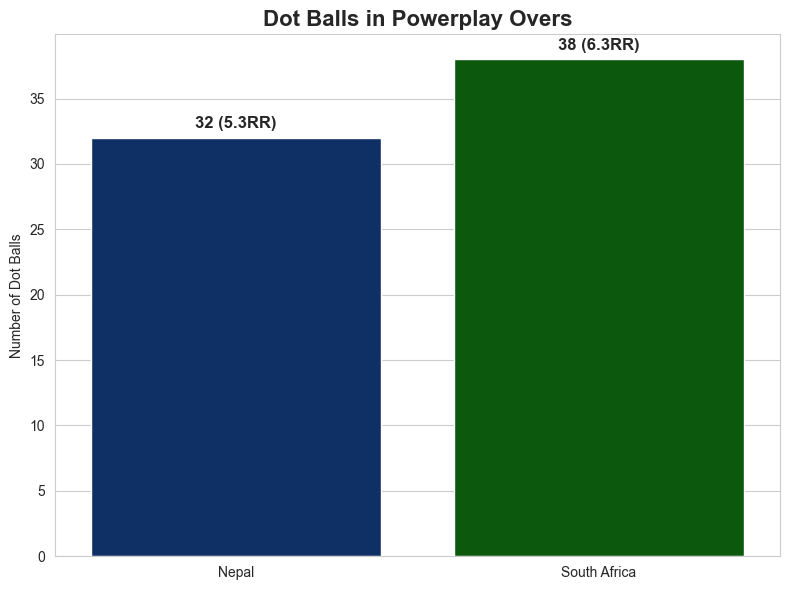

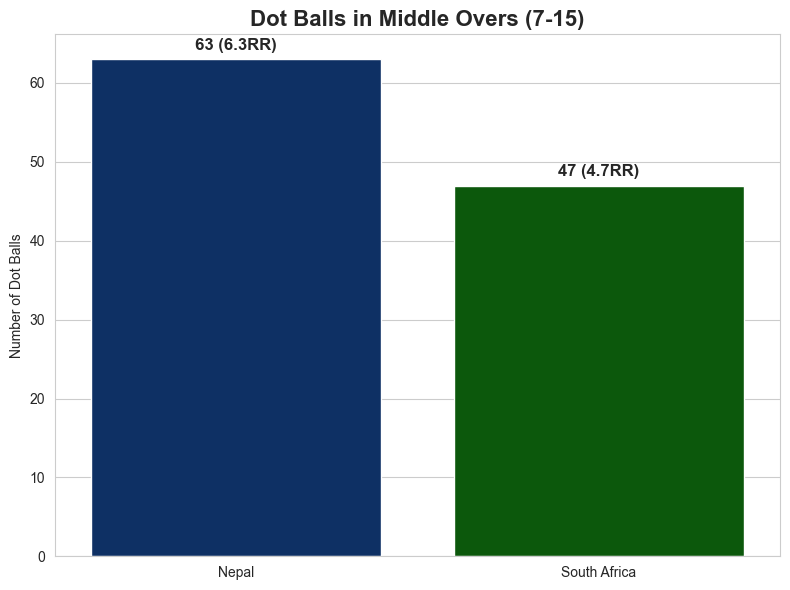

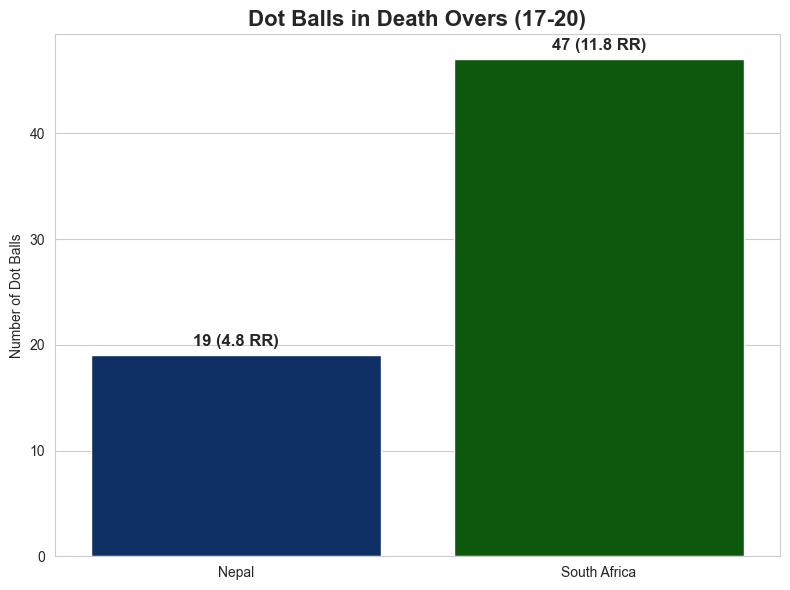

In [128]:
# Seaborn plot Nepal and South Africa runs scored pp, middle and death over, bar graph

print(f"South Africa - Powerplay: {runs_scored_pp_sa}, Middle Overs: {runs_scored_md_sa}, Death Overs: {runs_scored_dt_sa}")
print(f"Nepal - Powerplay: {runs_scored_pp_npl}, Middle Overs: {runs_scored_md_npl}, Death Overs: {runs_scored_dt_npl}")

# Total overs  for each phase
total_pp = 6
total_middle = 10
total_death = 4

# Create three separate plots for each phase

# Powerplay
data_pp = [
    {'Team': 'Nepal', 'Runs scored': runs_scored_pp_npl},
    {'Team': 'South Africa', 'Runs scored': runs_scored_pp_sa},
]
df_pp = pd.DataFrame(data_pp)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_pp, x='Team', y='Runs scored', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    run_rate = (height / total_pp).round(1)
    ax.annotate(f'{int(height)} ({run_rate}RR)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Powerplay Overs', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/runs_scored_powerplay.png", dpi=300, transparent=True)
plt.show()

# Middle Overs
data_md = [
    {'Team': 'Nepal', 'Runs scored': runs_scored_md_npl},
    {'Team': 'South Africa', 'Runs scored': runs_scored_md_sa},
]
df_md = pd.DataFrame(data_md)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_md, x='Team', y='Runs scored', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    run_rate = (height / total_middle).round(1)
    ax.annotate(f'{int(height)} ({run_rate}RR)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Middle Overs (7-15)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/run_scored_middle.png", dpi=300, transparent=True)
plt.show()

# Death Overs
data_dt = [
    {'Team': 'Nepal', 'Runs scored': runs_scored_dt_npl},
    {'Team': 'South Africa', 'Runs scored': runs_scored_md_sa},
]
df_dt = pd.DataFrame(data_dt)

plt.figure(figsize=(8, 6))
# sns.set_style("whitegrid")
ax = sns.barplot(data=df_dt, x='Team', y='Runs scored', hue='Team', palette=['#002D72', '#006400'], legend=False)
for i, p in enumerate(ax.patches):
    height = p.get_height()
    run_rate = (height / total_death ).round(1)
    ax.annotate(f'{int(height)} ({run_rate} RR)', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12, fontweight='bold')
plt.title('Dot Balls in Death Overs (17-20)', fontsize=16, fontweight='bold')
plt.ylabel('Number of Dot Balls')
plt.xlabel('')
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/runs_scored_death.png", dpi=300, transparent=True)
plt.show()

In [133]:
# Number of Runs in boundaries for South Africa, where runs_batter = 4 or 6 , sum
boundary_runs_sa = df_innings_1[df_innings_1['runs_batter'].isin([4, 6])]['runs_batter'].sum()
boundary_runs_np = df_innings_2[df_innings_2['runs_batter'].isin([4, 6])]['runs_batter'].sum()

print(f"Total boundary runs for South Africa: {boundary_runs_sa}")
print(f"Total boundary runs for Nepal   : {boundary_runs_np}")


Total boundary runs for South Africa: 52
Total boundary runs for Nepal   : 60


In [135]:
# Number of Runs in singes for South Africa, where runs_batter = 4 or 6 , sum
singles_runs_sa = df_innings_1[df_innings_1['runs_batter'].isin([1])]['runs_batter'].sum()
singles_runs_np = df_innings_2[df_innings_2['runs_batter'].isin([1])]['runs_batter'].sum()
print(f"Total Singles runs for South Africa: {singles_runs_sa}")
print(f"Total Singles runs for Nepal   : {singles_runs_np}")

Total Singles runs for South Africa: 44
Total Singles runs for Nepal   : 35


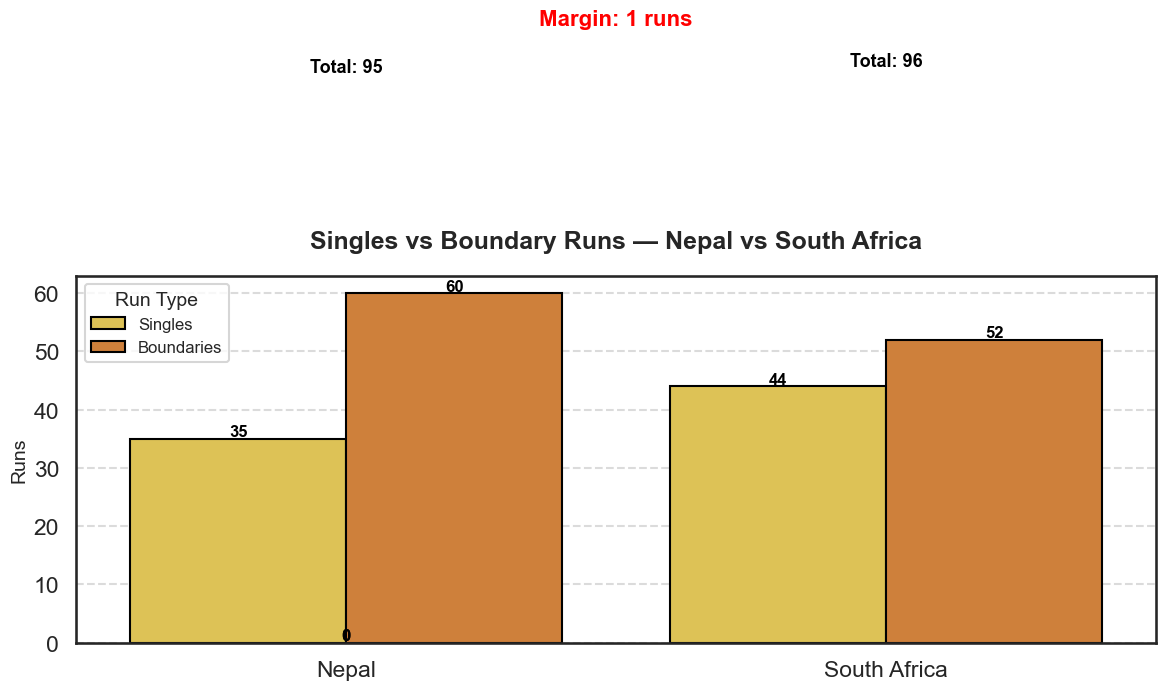

In [142]:
# graph the total boundary runs for South Africa and Nepal, and in the same graph, Total runs in singles runs for Nepal and South Africa,
# And then the differnce between them , what is the best graph to show this

# Data
data = {
    'Team': ['Nepal', 'South Africa'],
    'Singles': [singles_runs_np, singles_runs_sa],
    'Boundaries': [boundary_runs_np, boundary_runs_sa]
}

df = pd.DataFrame(data)

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars='Team', value_vars=['Singles', 'Boundaries'], var_name='Run Type', value_name='Runs')

# Colors
team_colors = {'Nepal': '#002D72', 'South Africa': '#006400'}
run_type_colors = {'Singles': '#F4D03F', 'Boundaries': '#E67E22'}

# Plot
plt.figure(figsize=(12, 10))
sns.set_theme(style="white", context="talk")

ax = sns.barplot(
    data=df_melted,
    x='Team',
    y='Runs',
    hue='Run Type',
    palette=run_type_colors,
    edgecolor='black',
    linewidth=1.5
)

# Add value labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Calculate totals and difference
total_np = df['Singles'][0] + df['Boundaries'][0]
total_sa = df['Singles'][1] + df['Boundaries'][1]
diff = abs(total_sa - total_np)

# Annotate totals
for i, team in enumerate(df['Team']):
    total = df['Singles'][i] + df['Boundaries'][i]
    ax.text(
        i, total + 3, f'Total: {total}',
        ha='center', fontsize=13, fontweight='bold', color='black'
    )

# Annotate difference
ax.text(
    0.5, max(total_np, total_sa) + 10,
    f'Margin: {diff} runs',
    ha='center', fontsize=16, fontweight='bold', color='red'
)

plt.ylabel('Runs', fontsize=14)
plt.xlabel('', fontsize=14)
plt.title('Singles vs Boundary Runs — Nepal vs South Africa', fontsize=18, fontweight='bold', pad=20)
plt.legend(title='Run Type', fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(root_dir/"TCG_git/Where did Nepal lose the South Afirca game?/output/singles_vs_boundaries.png", dpi=300, transparent=True)
plt.show()

In [213]:
# merge pp1 and pp2 dataframes
runs_summary_pp = pp_1.merge(pp_2, left_index=True, right_index=True, how='outer', suffixes=('_SA', '_NPL'))
runs_summary_pp = runs_summary_pp.fillna(0).astype(int)
runs_summary_pp

,count_SA,count_NPL
runs_batter,,
0,21,27
1,9,4
2,1,0
4,5,4
6,0,1


In [214]:
# merge md1 and md2 dataframes
runs_summary_md = md_1.merge(md_2, left_index=True, right_index=True, how='outer', suffixes=('_SA', '_NPL'))
runs_summary_md = runs_summary_md.fillna(0).astype(int)
runs_summary_md


,count_SA,count_NPL
runs_batter,,
0,29,26
1,26,26
2,1,2
4,3,4
6,1,2


In [227]:
# merge death overs dataframes
runs_summary_dt = dt_1.merge(dt_2, left_index=True, right_index=True, how='outer', suffixes=('_SA', '_NPL'))
runs_summary_dt = runs_summary_dt.fillna(0).astype(int)
runs_summary_dt


,count_SA,count_NPL
runs_batter,,
0,9,15
1,9,5
2,3,2
4,2,1
6,1,1


In [221]:
# Singles for individual Nepali batters in how many balls by name in middle overs from the df_2
singles_md_2 = df_2[(df_2.over >= 6) & (df_2.over <= 15) & (df_2.runs_batter == 1)]
singles_md_2_count = singles_md_2['batter'].value_counts()
singles_md_2_count

batter
Aasif Sheikh    13
AK Sah           7
DS Airee         5
K Bhurtel        1
Name: count, dtype: int64

In [222]:
# Aasif Sheikh value counts for runs in powerplay overs in innings 2
m = df_2[(df_2.over < 6) & (df_2.batter == 'Aasif Sheikh')]
m['runs_batter'].value_counts()

runs_batter
0    13
4     3
1     2
Name: count, dtype: int64

In [225]:
# Aasif Sheikh value counts for runs in powerplay overs in innings 2
m = df_2[(df_2.over < 6) & (df_2.batter == 'K Bhurtel')]
m['runs_batter'].value_counts()

runs_batter
0    14
1     2
4     1
6     1
Name: count, dtype: int64

In [ ]:
# Aasif Sheikh value counts for runs in middle overs in innings 2
    
m = df_2[(df_2.over >= 6) & (df_2.over <= 15) & (df_2.batter == 'Aasif Sheikh')]
m['runs_batter'].value_counts()

runs_batter
1    13
0     9
4     1
6     1
2     1
Name: count, dtype: int64

In [226]:
    
m = df_2[(df_2.over >= 6) & (df_2.over <= 15) & (df_2.batter == 'K Bhurtel')]
m['runs_batter'].value_counts()

runs_batter
0    2
1    1
Name: count, dtype: int64